<html>
<div>
  <img src="https://www.engineersgarage.com/wp-content/uploads/2021/11/TCH36-01-scaled.jpg" width=360px width=auto style="vertical-align: middle;">
  <span style="font-family: Georgia; font-size:30px; color: white;"> <br/> University of Tehran <br/> AI_CA6_P2 <br/> Spring 02 </span>
</div>
<span style="font-family: Georgia; font-size:15pt; color: white; vertical-align: middle;"> low_mist - std id: 810100186 </span>
</html>

In this notebook we are implement and train a Convolutional Neural Network to classify images.

## Problem Description
in this problem we will learn more about `Neural Network` and specially about `CNN` (i.e. Convolutional Neural Network). for Part. 1 we train a model for a dataset and classify them. Then we learn about unbalanced datasets, and we use data augmentation techniques to improve the performance of our model. At the end we learn about regularization techniques and how to use them to improve the performance of our model.

In [11]:
from __future__ import annotations

# data manipulation
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from abc import ABC, abstractmethod
import math

# data visualization
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
import plotly.express as px
import plygdata as pg

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
)
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# types
from dataclasses import dataclass
from enum import Enum
from typing import Union, Iterable, Callable, Optional
from collections import namedtuple, Counter

# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Activation,
    Input,
    Flatten,
    BatchNormalization,
)
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10

## torch
import torch
from torch import nn, optim
from torch.nn import ReLU, Sigmoid, Linear
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import grad

# utils
import os
from tqdm import tqdm
import difflib
import urllib.request
import tarfile
import random

### Part 0. Preprocessing the dataset.
In this notebook we will train our CNN on CIFAR-10 dataset. The CIFAR-10 dataset is a collection of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is designed for image classification tasks, where the goal is to assign a label to each image indicating which of the 10 classes it belongs to. The classes are mutually exclusive and correspond to common objects in our daily life such as airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

The dataset is divided into two sets: a training set and a test set. The training set contains 50,000 images, while the test set contains 10,000 images. The images in the training set are used to train machine learning models, while the images in the test set are used to evaluate the performance of the models.

The CIFAR-10 dataset is widely used in the machine learning community as a benchmark for evaluating the performance of image classification algorithms. Many state-of-the-art models have been trained on this dataset, and it has become a standard benchmark for comparing the performance of different models.

In addition to the original CIFAR-10 dataset, there are also several variations of the dataset that have been created over the years. For example, there is a CIFAR-100 dataset that contains 100 classes of objects, and there is a CIFAR-10.1 dataset that is designed to be more challenging than the original CIFAR-10 dataset.

In [15]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

filepath = './cifar-10-python.tar.gz'

if os.path.exists(filepath):
    os.remove(filepath)

# urllib.request.urlretrieve(url, filepath)

# with tarfile.open(filepath, 'r:gz') as tar:
#     tar.extractall()


In [26]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

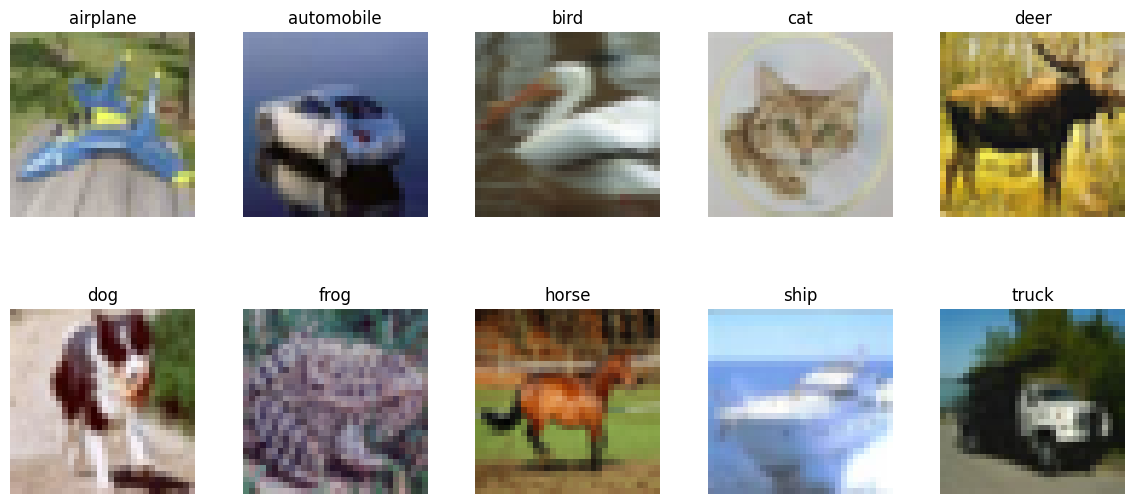

In [27]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class_images = {}
for i in range(len(class_names)):
    index = random.randint(0, len(x_train) - 1)
    while y_train[index][0] != i:
        index = random.randint(0, len(x_train) - 1)
    class_images[class_names[i]] = x_train[index]

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(len(class_names)):
    axs[i].imshow(class_images[class_names[i]], cmap=plt.cm.binary)
    axs[i].set_title(class_names[i])
    axs[i].axis('off')
plt.show()

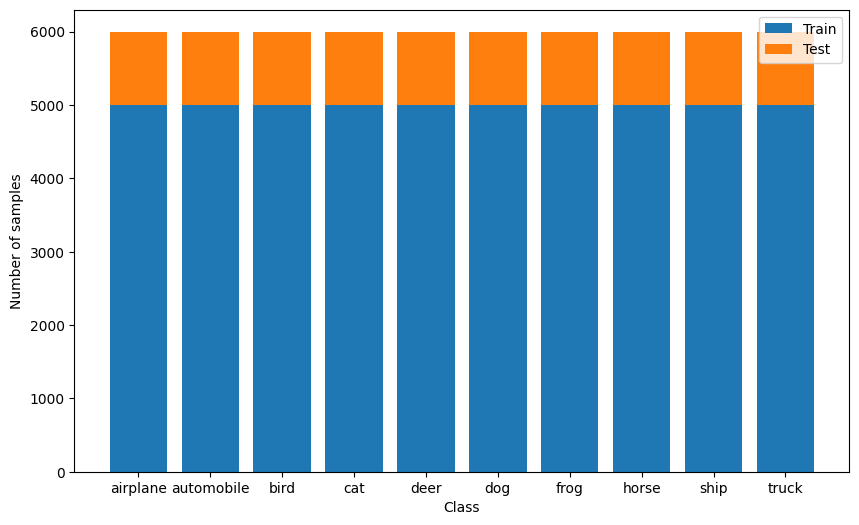

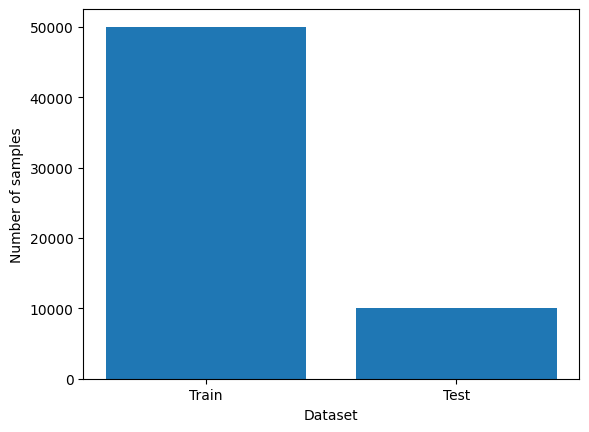

In [28]:
train_counts = [0 for _ in range(len(class_names))]
test_counts = [0 for _ in range(len(class_names))]

for label in y_train:
    train_counts[int(label)] += 1

for label in y_test:
    test_counts[int(label)] += 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(class_names, train_counts, label='Train')
ax.bar(class_names, test_counts, bottom=train_counts, label='Test')
ax.set_ylabel('Number of samples')
ax.set_xlabel('Class')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.bar(['Train', 'Test'], [len(x_train), len(x_test)])
ax.set_ylabel('Number of samples')
ax.set_xlabel('Dataset')
plt.show()

Now we `Normalize` pictures and use `OneHot encoding` to encode the labels.  
`Normalization` is a common preprocessing step in machine learning that involves scaling the input data to have zero mean and unit variance. Normalizing the input data can help improve the performance of machine learning models by making the optimization process more efficient and reducing the impact of differences in the scale of the input features.  
`OneHot encoding` is a technique used to represent categorical data as numerical data. In machine learning, many algorithms require numerical input data, and one-hot encoding is a way to convert categorical data into a numerical format that can be used as input to these algorithms.

In one-hot encoding, each category is represented as a binary vector of length equal to the number of categories. The vector has a value of 1 in the position corresponding to the category and 0 in all other positions. For example, suppose we have a categorical variable "color" with three categories: red, green, and blue. We can represent these categories using one-hot encoding as follows:

| Color | One-hot encoding |
|-------|------------------|
| Red   |     [1, 0, 0]    |
| Green |     [0, 1, 0]    |
| Blue  |     [0, 0, 1]    |

One-hot encoding is useful because it allows us to represent categorical data in a way that is compatible with many machine learning algorithms. For example, we can use one-hot encoding to represent categorical variables in a neural network by treating the binary vectors as input features. One-hot encoding also ensures that the numerical representation of the categories does not imply any ordering or hierarchy between the categories, which is important for many applications.

However, one-hot encoding can lead to high-dimensional input data, especially if there are many categories. In some cases, it may be more efficient to use other encoding techniques, such as `label encoding` or `binary encoding`, which can represent categorical data using fewer dimensions.

Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)


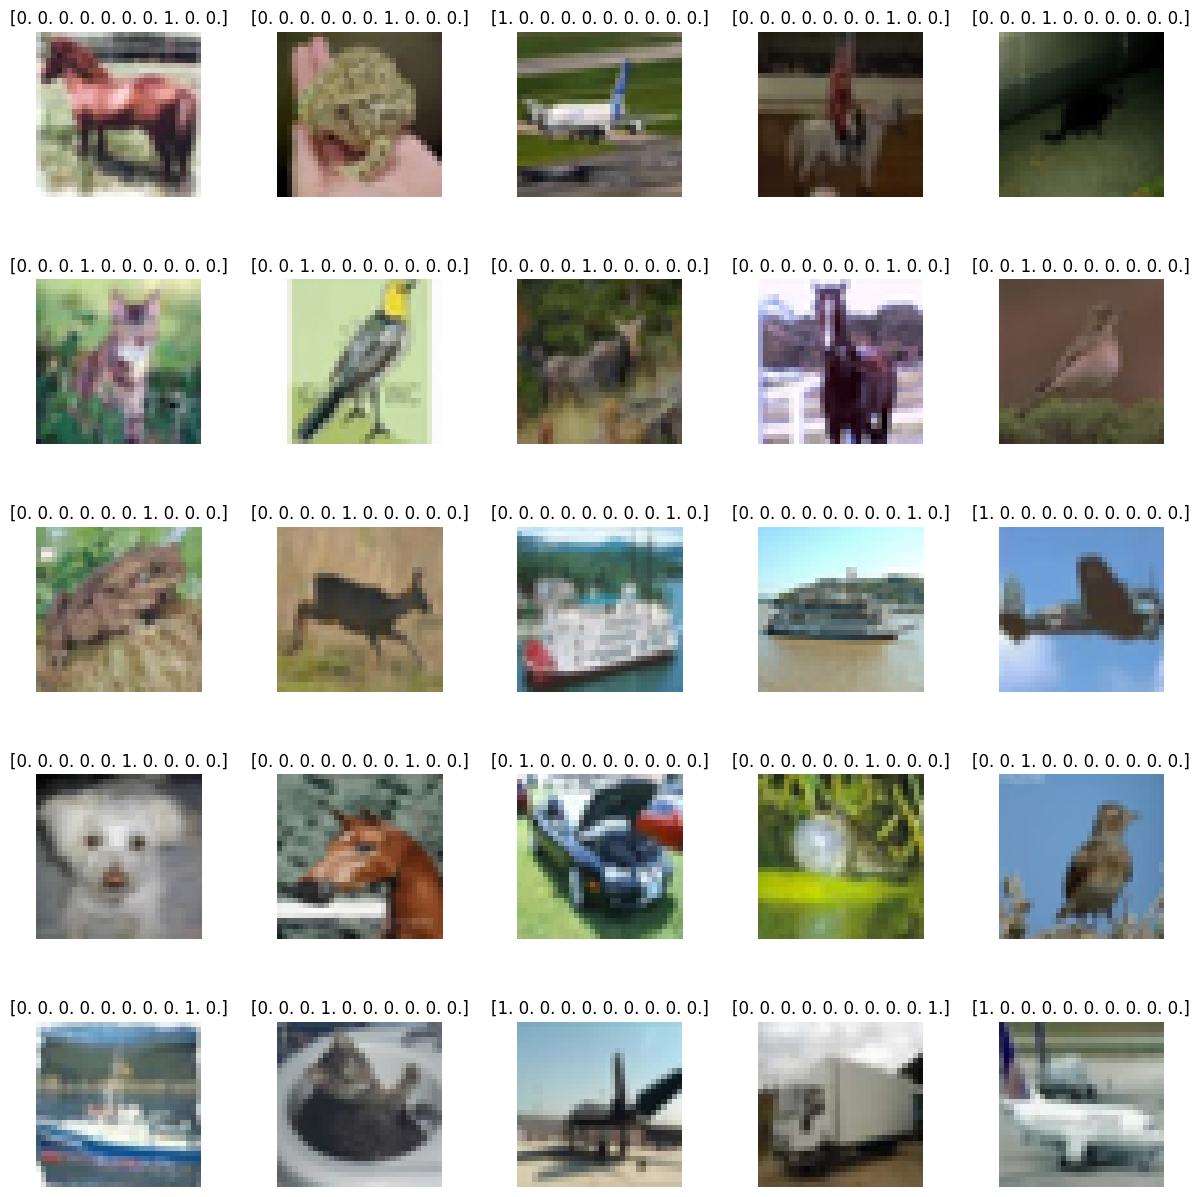

In [30]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
axes = axes.ravel()

for i in np.arange(0, 25):
    index = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[index])
    axes[i].set_title(y_train[index])
    axes[i].axis("off")

plt.subplots_adjust(hspace=0.5)

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
cnn.add(Activation("relu"))
cnn.add(Conv2D(32, (3, 3)))
cnn.add(Activation("relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, (3, 3), padding="same"))
cnn.add(Activation("relu"))
cnn.add(Conv2D(64, (3, 3)))
cnn.add(Activation("relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(512))
cnn.add(Activation("relu"))
cnn.add(Dense(10))
cnn.add(Activation("softmax"))
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
log = cnn.fit(
    x_train,
    y_train_onehot,
    batch_size=32,
    epochs=20,
    validation_data=(x_test, y_test_onehot),
)

preprocess

cnn

In [ ]:
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding="same", input_shape=x_train.shape[:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(256, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation("softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(lr=lr_schedule(0)),
        metrics=["accuracy"],
    )

    return model


def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 20:
        lr *= 0.5e-3
    elif epoch > 15:
        lr *= 1e-3
    elif epoch > 10:
        lr *= 1e-2
    elif epoch > 5:
        lr *= 1e-1
    print("Learning rate:", lr)
    return lr


def fit_cnn_model(model: Sequential, x_train, y_train, x_test, y_test, batch_size=32, epochs=30):
    log = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=[LearningRateScheduler(lr_schedule)],
    )
    return log


model = create_cnn_model()
log = fit_cnn_model(
    model, x_train, y_train_onehot, x_test, y_test_onehot, batch_size=32, epochs=30
)